<a href="https://colab.research.google.com/github/knobs-dials/wetsuite-notebooks/blob/main/beginnings_minimal_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Purpose of this notebook

To give some examples in the form of short snippets, to show the kind of thing you can expect from this package.

In [ ]:
# (only) in colab, run this first to install wetsuite from (the most recent) source.   For your own setup, see wetsuite's install guidelines.
!pip3 install -U --no-cache-dir --quiet https://github.com/knobs-dials/wetsuite-dev/archive/refs/heads/main.zip

## Datasets
Ideally, data we already provide is a basis for you to go on. 
For example:

### Kamervragen


In [11]:
import wetsuite.datasets, random

kamervragen = wetsuite.datasets.load('tweedekamer-kamervragen-struc')

# As  print( kv.description )   will point out,  kv.data  contains a nested structure, so some informed wrangling is necessary:
source_ref, vraag_document = kamervragen.data.random_choice()
for vraag_number in vraag_document['vraagdata']: 
    vraag_n_text,    _ = vraag_document['vraagdata'][vraag_number].get('vraag')
    antwoord_n_text, _ = vraag_document['vraagdata'][vraag_number].get('antwoord')

    print(  ' Q%-5s  %s'%( vraag_number, vraag_n_text   )  )
    print(  ' A%-5s  %s'%( vraag_number, antwoord_n_text)  )
    print('----')

 Q1      Bent u bekend met de ingezonden reactie in Medisch Contact «Helder taalgebruik overheid»? Wat vindt u van dit bericht?
 A1      Ja, wij zijn bekend met dit bericht. Wij vinden het positief dat er aandacht is voor de handreikingen schriftelijk euthanasieverzoek. Het is goed om te merken dat de teksten zorgvuldig worden gelezen.
----
 Q2      Kunt u nader toelichten op welke wijze de tekst van de brochure, zowel de versie voor artsen als de publieksversie, tot stand gekomen is? Hoe is ervoor gezorgd dat de teksten geen verwachtingen wekken over een ruimere interpretatie van de euthanasiewetgeving?
 A2      De aanleiding voor het opstellen van de handreikingen was de bestaande discussie over de reikwijdte van de euthanasiewet (Wet toetsing levensbeëindiging op verzoek en hulp bij zelfdoding, Wtl). In het bijzonder ontstond er in het voorjaar van 2013 maatschappelijke discussie over de betekenis en waarde van de schriftelijke wilsverklaring. Op basis van een aan uw Kamer gedane to

See [dataset_kamervragen (notebook)](dataset_intro_by_doing__kamervragen__%28stats_example%29.ipynb) for a little more in that specific dataset. 

See [intro_datasets (notebook)](dataset_intro_by_doing__0intro.ipynb) for more details for more datasets.


## Working on text


### Extract plain text fragments (from BWB)
For some broader tasks, where complete but structureless, flat text is enough, there is a dataset. 

Instead, this secion is about wanting more control than that: Laws are of course structured, with paragraphs and lists, 
in an artikel, in a hoofdstuk, and more, and when you want to portion the text by those, or summarize sections, 
or actively use references to such parts, then you need a to understand and use all that structure, 
and probably want more assistance than "Here is the XML (or HTML), good luck".

We aim to let you flatten text with a granularity that you can control, e.g. per article, per hoofdstuk, or otherwise.

And also give an indication to where it came from within the document it came from, 
for the more advanced use of "use the intermediate form to then go interrogate the fully detailed original data".

Consider:

In [13]:
import pprint,  wetsuite.helpers.net, wetsuite.helpers.etree, wetsuite.helpers.koop_parse
example_et = wetsuite.helpers.etree.fromstring(     # intentionally a very short example document.
    wetsuite.helpers.net.download( 'https://repository.officiele-overheidspublicaties.nl/bwb/BWBR0007878/1996-02-04_0/xml/BWBR0007878_1996-02-04_0.xml' )
)

alinea_dicts = wetsuite.helpers.koop_parse.alineas_with_selective_path( example_et )  # this gives a detailed inbetween state that can be merged in varied ways
merged       = wetsuite.helpers.koop_parse.merge_alinea_data( alinea_dicts )          # th 

for ref , text in merged:
    print( '%-30s %s'%( ref, text) )


[]                             ['Besluit: ', 'Deze regeling zal met de toelichting in de Staatscourant worden geplaatst. ']
[('artikel', '1')]             ['De door de ondernemers voor het jaar 1996 vastgestelde tarieven worden goedgekeurd. ']
[('artikel', 'II')]            ['Deze regeling treedt in werking met ingang van de tweede dag na dagtekening van de Staatscourant waarin zij wordt geplaatst en werkt terug tot en met 1 januari 1996. ']



The above relies on some defaults we don't explain in this introduction, also dealing with observed variation in those higher-level layers.
See [datacollect_koop_docstructure_bwb (notebook)](notebooks/extras/extras_datacollect_koop_docstructure_bwb.ipynb) for more explanation
and how to dive in deeper into the details.

We are still considering the balance between more convenient, controllable, and complete, so this code will likely change.




### Entity extraction (with spaCy)

TODO

(link to notebook)

 


### Relation extraction (with spaCy)
TODO




### Word cloud, and kansspelbeschikkingen data
Word clouds are a simple [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)-style visualisation.
This means using no structur or parsing, _just_ just the presence of each of the words,
yet sometimes it is enough to give a basic idea of what a document focuses on.

In [ ]:
!python3 -m spacy download nl_core_news_lg
# ...because the spacy helper used here 

https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/goldwin-limited/


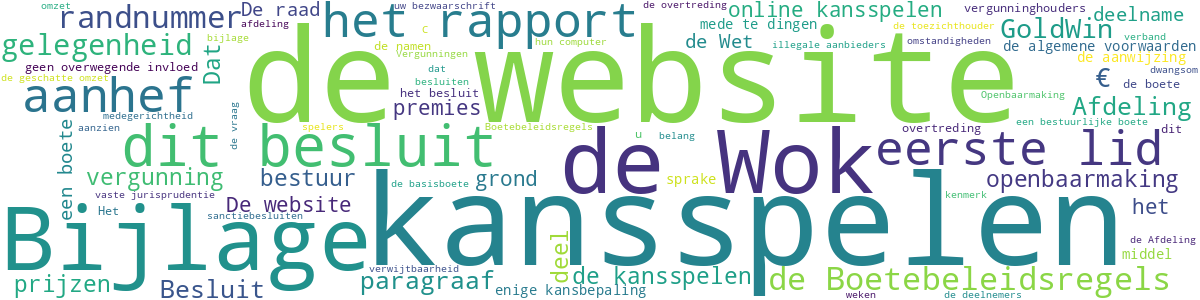

https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/raging-rhino/


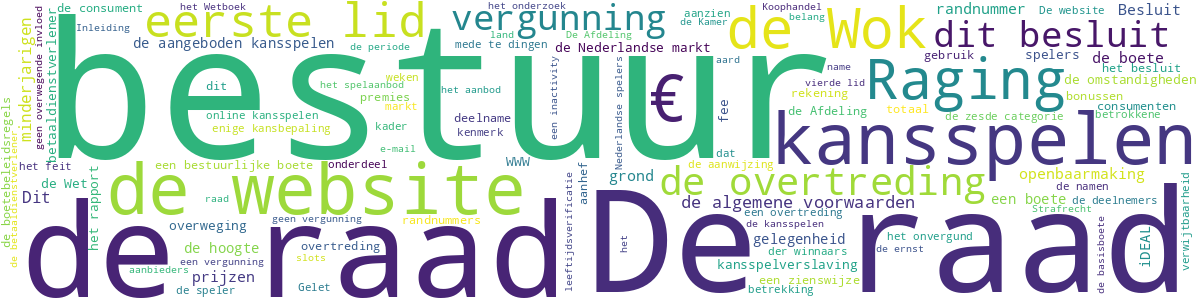

https://kansspelautoriteit.nl/aanpak-misstanden/sanctiebesluiten/holland-gaming/


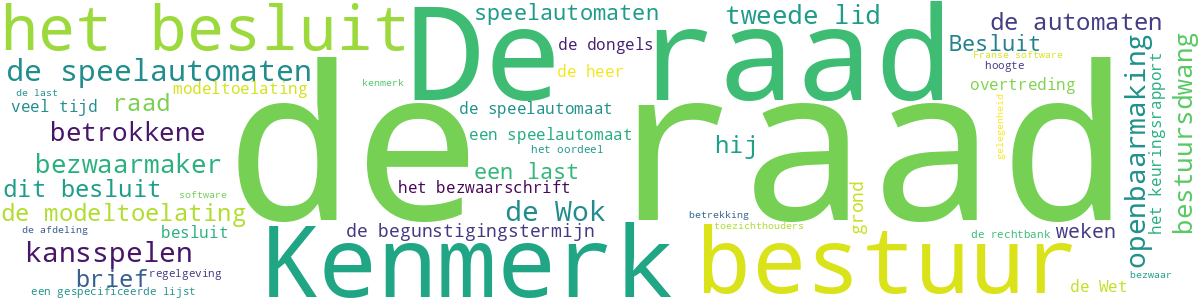

In [2]:
import wetsuite.datasets, wetsuite.helpers.spacy, wetsuite.helpers.strings, wetsuite.extras.word_cloud

ks = wetsuite.datasets.load('kansspelautoriteit-sancties-struc')

# again, most lines are wrangling of structured data
for case_ref, case_details in ks.data.random_sample(3):
    print( case_ref)
    case_phrases = []  # we try to only get out nouns and noun phrases.  Using all words would go a lot faster  yet would include a lot of empty function words
    for doc_details in case_details['docs']:
        for page in doc_details['pages']:
            for page_text_fragment in page['body_text']:
                case_phrases.extend( wetsuite.helpers.spacy.nl_noun_chunks( page_text_fragment ) ) # use spacy to extract what seems like phrases from plain text
    counts = wetsuite.helpers.strings.count_normalized( case_phrases, stopwords_i=['de kansspelautoriteit', 'artikel', 'zij','die', 'de'] )
    im = wetsuite.extras.word_cloud.wordcloud_from_freqs( counts )
    display( im )  # display() exists in the context of python notebooks, elsewhere you might e.g.   im.save( '%s.png'%case_details['name'] ) 


### Topic modeling

The widest sense of topic modeling is an iterative, interpreting, 
somewhat creative process (unless it's referring to pre-trained labeling).

That said...

TODO: short example from the


## Search
Various goverment systems offer live search, in website and/or data form.

Each has its own features, limitations, and idiosyncracies, and potentially their own document structure to deal with.
The most controlled way is often to learn and use each one individually.

We can at least ease that process, with explorations and explanations, and code to ease access.

More effort will be made once we decide the best course of action.

Also, since we have datasets, we provisionally provide a search of those,
as that should at least put a single interface on all data wet put in there.
If there is interest may may later explain how to set up your own.


### Search by keyword (in CVDR)


import pprint, wetsuite.datacollect.koop_sru, wetsuite.helpers.koop_parse

cvdr = wetsuite.datacollect.koop_sru.CVDR() # object informed about that backend, and has a search function
for hit_et in cvdr.search_retrieve_many( 'body any visserij', up_to=50 ):
    pprint.pprint(  wetsuite.helpers.koop_parse.cvdr_meta( hit_et, flatten=True )  )



In [27]:
import pprint, wetsuite.datacollect.koop_sru, wetsuite.helpers.koop_parse

cvdr = wetsuite.datacollect.koop_sru.CVDR() # object informed about that backend, and has a search function
for hit_et in cvdr.search_retrieve_many( 'body any visserij', up_to=3 ):
    pprint.pprint(  wetsuite.helpers.koop_parse.cvdr_meta( hit_et, flatten=True )  )


{'alternatieveIdentifier': '',
 'alternative': 'Instellingsbesluit Dienst Landbouw, Veeteelt,\n'
                '        Visserij',
 'betreft': 'Nieuwe regeling',
 'creator': 'Bonaire (overheid:CaribischOpenbaarLichaam)',
 'gedelegeerdeRegelgeving': '<al>Geen</al>',
 'identifier': '2016_2',
 'indeling': 'overig',
 'inwerkingtredingDatum': '1987-03-17',
 'isFormatOf': 'A.B. 1987, no. 5 ()',
 'isRatifiedBy': 'Bestuurscollege '
                 '(overheid:BestuursorgaanAnderOpenbaarLichaam)',
 'issued': '1987-02-18',
 'kenmerk': 'Onbekend',
 'language': 'nl',
 'modified': '2010-12-20',
 'omgevingswet': 'nee',
 'onderwerp': '',
 'opvolgerVan': '',
 'organisatietype': 'CaribischOpenbaarLichaam',
 'preferred_url': 'https://lokaleregelgeving.overheid.nl/2016/2',
 'publicatieurl_xhtml': 'https://repository.officiele-overheidspublicaties.nl/cvdr/CVDR2016/2/html/2016_2.html',
 'publicatieurl_xml': 'https://repository.officiele-overheidspublicaties.nl/cvdr/CVDR2016/2/xml/2016_2.xml',
 'redaction



See [datacollect_koop_repos (notebook)](notebooks/extras/extras_datacollect_koop_sru_repos.ipynb) for more details.

### Search recent law changes (in BWB)

In [28]:
import pprint, wetsuite.datacollect.koop_sru, wetsuite.helpers.koop_parse

bwb = wetsuite.datacollect.koop_sru.BWB()
for hit_et in bwb.search_retrieve_many( 'dcterms.modified >= 2023-03-01', up_to=3 ):
    pprint.pprint( wetsuite.helpers.koop_parse.bwb_searchresult_meta( hit_et ) )

{'authority': 'Veiligheid en Justitie',
 'created': '2015-07-01',
 'creator': 'Ministerie van Binnenlandse Zaken en Koninkrijksrelaties',
 'geldigheidsperiode_einddatum': '2002-06-30',
 'geldigheidsperiode_startdatum': '2002-01-01',
 'identifier': 'BWBR0001827',
 'language': 'nl',
 'locatie_manifest': 'https://repository.officiele-overheidspublicaties.nl/bwb/BWBR0001827/manifest.xml',
 'locatie_toestand': 'https://repository.officiele-overheidspublicaties.nl/bwb/BWBR0001827/2002-01-01_0/xml/BWBR0001827_2002-01-01_0.xml',
 'locatie_wti': 'https://repository.officiele-overheidspublicaties.nl/bwb/BWBR0001827/BWBR0001827.WTI',
 'modified': '2024-02-22',
 'overheidsdomein': 'Rechtspraak',
 'rechtsgebied': 'Burgerlijk procesrecht',
 'title': 'Wetboek van Burgerlijke Rechtsvordering (geldt in geval van '
          'digitaal procederen)',
 'toestand': 'http://wetten.overheid.nl/id/BWBR0001827/2002-01-01/0',
 'type': 'wet',
 'zichtperiode_einddatum': '9999-12-31',
 'zichtperiode_startdatum': '2

## Data collection

Often enough, documents or datasets that exist out there aren't quite enough,
and you will have collect and organize your own.


### PDF
One aspect is that the government is only required to try to give the most machine-readable version they have,
and sometimes the best version is PDFs.

Can we extract the text it says it contains?  You can ask the PDF about the text it says it contains, and often that works:


In [2]:
import wetsuite.helpers.net
import wetsuite.extras.pdf

pdfbytes = wetsuite.helpers.net.download('https://open.overheid.nl/documenten/ronl-5439f4bf9849a53e634389ebbb5e4f5740c4f84f/pdf')
text_per_page = wetsuite.extras.pdf.page_text( pdfbytes )
print( next(text_per_page) ) # print just the first page, the whole thing is too much
#print(  '---------NEWPAGE---------'.join( text_per_page )  )

 
 
 
 
 
 
> Retouradres Postbus 40219 8004 DE Zwolle 
  
 
 
 
Rijksdienst voor 
Ondernemend Nederland 
Vergunningen en handhaving 
  
Mandemaat 3, Assen 
Postbus 40219 
8004 DE Zwolle 
www.rvo.nl 
 
Contactpersoon 
 
Woo-medewerker 
  
T 0880 42 4242 
woo-unit@rvo.nl 
    
Onze referentie 
Woo/2023/035 
 
Datum 29 maart 2023 
Betreft Beslissing op verzoek Woo/2023/035 
 
Bijlagen 
2 
Relatienummer 
 
  
  
  
  
  
 
 
 
 
 
 
 
 
 
 
Geachte heer 
, 
 
 
 
Op 15 februari 2023 heb ik uw verzoek ontvangen waarin u vraagt om 
openbaarmaking van informatie. In deze brief leest u mijn reactie op uw verzoek. 
 
Uw verzoek 
U vraagt om openbaarmaking van informatie over de definitieve 
investeringsverklaring(en) verleend in verband met de verbouw van 220 woningen 
met projectnummer RVVN200264. 
 
Procedure 
De ontvangst van uw verzoek is schriftelijk bevestigd bij brief van  
17 februari 2023 met kenmerk Woo/2023/035. In deze brief is tevens de 
beslistermijn met twee weken verdaagd. 
 
O

However, it turns out there are many PDFs that (partially or fully) contain **images of text**.

To check the just-mentioned PDF, you can e.g. 

In [3]:
chars_per_page, num_pages_with_text, num_pages = wetsuite.extras.pdf.count_pages_with_text(pdfbytes, char_threshold=150)
print(f'{num_pages_with_text} out of {num_pages} pages contain reasonable amount of text\n\nCharacters per page: {chars_per_page}')
# which will point out that:

7 out of 20 pages contain reasonable amount of text

Characters per page: [1612, 2797, 816, 643, 2479, 2684, 481, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


That doesn't look right, so in this case we move on to...

### OCR

In [ ]:
import wetsuite.extras.ocr
fragments, justtext = wetsuite.extras.ocr.ocr_pdf_pages( pdfbytes ) 
# fragments is more structured, but needs interpretation,  so is only interesting for more advanced use.

# If you just care about the text, well:
#print('\n ----- PAGE BREAK -----\n'.join(justtext) )

In [7]:
# but right now we don't care for the text contents, just that it's there:
for page_num, pagetext in enumerate(justtext):
    print( page_num, len(pagetext) )

0 1501
1 2692
2 700
3 595
4 2343
5 2550
6 396
7 1442
8 2134
9 1132
10 1091
11 1177
12 1148
13 1136
14 1093
15 504
16 1261
17 1010
18 837
19 382


See [this datacocr-or-pdf notebook](research-methods/methods_technical__pdf_part1__extract_or_ocr.ipynb) 
to get some insight on various limitations of OCR, and how you might improve that.

## 